## L98-59 Modelling

This notebook will contain the analysis of the L98-59 system. This project utilises data from HARPS and ESPRESSO, the analysis will be done using the RadVel package. 

### Get the data

##### HARPS data

$\bold{\text{Program IDs:}}$ 198.C-0838, 1102.C-0339, and 0102.C-0525

$\bold{\text{Observation Dates:}}$ Between October 17, 2018 (BJD = 2458408.5) and April 28, 2019 (BJD = 2458601.5)

##### ESPRESSO data

$\bold{\text{Program IDs:}}$  1102.C-0744, 1102.C-0958, and 1104.C-0350

$\bold{\text{Observation Dates:}}$ Between November 14, 2018 (BJD = 2458436.5), and March 4, 2020
(BJD = 2458912.5)


##### Data Access
https://archive.eso.org/cms.html

In [2]:
import emcee
import corner
import george
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from george import kernels
from scipy.optimize import minimize
from astropy.timeseries import LombScargle

### HARPS Data Unpack ESO
Unpack the SCIENCE.SPECTRUM data

In [2]:
# Open the .fits file (SCIENCE.SPECTRUM)
science_spectrum_file = 'ESO/ADP.2019-05-24T01:50:46.106.fits'
hdul = fits.open(science_spectrum_file)

# Display information about the .fits file
hdul.info()

# Inspect the headers of the first data extension
header = hdul[1].header
print("######################")
print(repr(header))

# List the column names and their data types
spectrum_data = hdul[1].data
print("######################")
print(spectrum_data.columns)

# Extract specific columns
wavelength = spectrum_data['WAVE'][0]
flux = spectrum_data['FLUX'][0]
error = spectrum_data['ERR'][0]

Filename: ESO/ADP.2019-05-24T01:50:46.106.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    3072   ()      
  1  SPECTRUM      1 BinTableHDU     46   1R x 3C   [313089D, 313089E, 313089E]   
######################
XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              5009424 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'WAVE    '                                                            
TFORM

/Users/maxtalberg/miniconda3/envs/rv-env/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


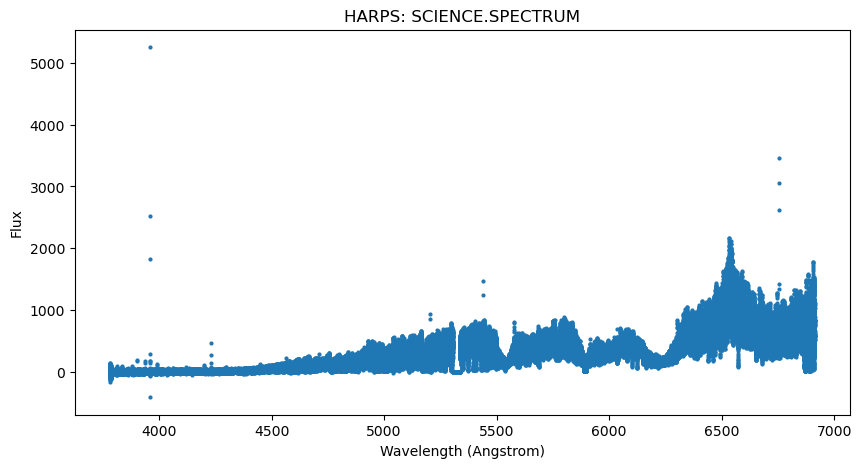

In [3]:
# Plot HARP SPECTRUM

plt.figure(figsize=(10, 5))
plt.errorbar(wavelength, flux, yerr=error, fmt='o', markersize=2, capsize=3)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux')
plt.title('HARPS: SCIENCE.SPECTRUM')
plt.show()

In [ ]:
# Open a .fits file
filename = 'ESO/data/reduced/2019-03-01/HARPS.2019-03-02T01:12:13.931_ccf_M2_A.fits'
hdul = fits.open(filename)

# Print the header
print(repr(hdul[0].header))

# Print the data shape and type
print(hdul[0].data.shape)
print(hdul[0].data.dtype)

# Close the file
hdul.close()

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  161 / length of data axis 1                          
NAXIS2  =                   73 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HIERARCH ESO DRS CCF RVC = 1.11552042800024 / Baryc RV (drift corrected) (km/s) 
HIERARCH ESO DRS CCF CONTRAST = 32.454773958003 / Contrast of  CCF (%)          
HIERARCH ESO DRS CCF FWHM = 2.93413018769811 / FWHM of CCF (km/s)               
HIERARCH ESO DRS CCF RV = 1.11552042800024 / Baryc RV (no drift correction) (km/
CRVAL1  =               -18.

: 

In [ ]:
import os

fits_dir = 'ESO/data/reduced/'

# Initialize lists to hold the data
times = []
rv_values = []
rv_errors = []

# Loop over all .fits files in the directory
for filename in os.listdir(fits_dir):
    if filename.endswith('.fits'):
        filepath = os.path.join(fits_dir, filename)
        
        with fits.open(filepath) as hdul:
            header = hdul[0].header
            data = hdul[0].data
            
            # Extract the observation time (e.g., BJD)
            observation_time = header['DATE']
            times.append(observation_time)
            
            # Extract the RV value
            rv = header['HIERARCH ESO DRS CCF RVC']
            rv_values.append(rv)
            
            # Extract the RV error
            rv_error = header['HIERARCH ESO DRS CCF NOISE']
            rv_errors.append(rv_error)

# Create a DataFrame
rv_data = pd.DataFrame({
    'Time': times,
    'RV': rv_values,
    'RV_Error': rv_errors
})


print(rv_data)

Empty DataFrame
Columns: [Time, RV, RV_Error]
Index: []


: 

### HARPS Data Unpack C19

In [3]:
# Define the column titles - Time (BJD-2457000)
column_titles = [
    'Time', 'RV', 'e_RV', 'Halpha', 'e_Halpha', 'Hbeta', 'e_Hbeta', 'Hgamma', 'e_Hgamma', 'NaD', 'e_NaD',
    'Sindex', 'e_Sindex', 'FWHM', 'BIS'
]

# load data
harps_df = pd.read_csv('C19/harps.dat', delim_whitespace=True, names=column_titles)


# Adjust the time column to BJD by adding 2457000
harps_df['Time'] += 2457000

harps_df.info()
harps_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      165 non-null    float64
 1   RV        165 non-null    float64
 2   e_RV      165 non-null    float64
 3   Halpha    165 non-null    float64
 4   e_Halpha  165 non-null    float64
 5   Hbeta     165 non-null    float64
 6   e_Hbeta   165 non-null    float64
 7   Hgamma    165 non-null    float64
 8   e_Hgamma  165 non-null    float64
 9   NaD       165 non-null    float64
 10  e_NaD     165 non-null    float64
 11  Sindex    165 non-null    float64
 12  e_Sindex  165 non-null    float64
 13  FWHM      165 non-null    object 
 14  BIS       165 non-null    object 
dtypes: float64(13), object(2)
memory usage: 19.5+ KB


,Time,RV,e_RV,Halpha,e_Halpha,Hbeta,e_Hbeta,Hgamma,e_Hgamma,NaD,e_NaD,Sindex,e_Sindex,FWHM,BIS
0,2.458409e+06,-5678.7,2.3,6.93,0.02,5.43,0.05,12.32,0.17,0.91,0.02,0.69,0.09,3.0588,23.2798
1,2.458410e+06,-5678.9,2.4,6.77,0.02,5.22,0.05,11.46,0.17,0.84,0.02,0.65,0.10,3.0637,23.3301
2,2.458413e+06,-5679.1,2.2,7.07,0.02,5.79,0.05,12.85,0.17,0.98,0.02,0.80,0.10,3.0559,23.3108
3,2.458414e+06,-5676.2,1.9,6.79,0.02,5.25,0.04,11.87,0.13,0.83,0.02,0.65,0.07,3.0655,23.3935
4,2.458415e+06,-5674.6,2.5,6.81,0.02,5.12,0.06,11.75,0.19,0.85,0.03,0.71,0.12,3.0560,23.1147


### Exlcude Specific Measurements

In [4]:
# Remove datapoints as performed in paper
'''
we had to exclude four measurements obtained
at 2 458 503.795048, 2 458 509.552019, 2 458 511.568314, and
2 458 512.581045 BJD. We identified these measurements with a
4σ iterative sigma clipping.
'''

# Define the BJDs to be excluded
excluded_bjds = [2458503.795048, 2458509.552019, 2458511.568314, 2458512.581045] 

# Exclude the specified BJDs
cleaned_df = harps_df[~harps_df['Time'].isin(excluded_bjds)].copy()

# Interpolate missing values (???)
cleaned_df['FWHM'] = cleaned_df['FWHM'].replace('---', 0).astype(float).interpolate(method='linear')
cleaned_df['BIS'] = cleaned_df['BIS'].replace('---', 0).astype(float).interpolate(method='linear')

cleaned_df.info()

# save the cleaned data
cleaned_df.to_csv('cleaned_harps_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 161 entries, 0 to 164
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      161 non-null    float64
 1   RV        161 non-null    float64
 2   e_RV      161 non-null    float64
 3   Halpha    161 non-null    float64
 4   e_Halpha  161 non-null    float64
 5   Hbeta     161 non-null    float64
 6   e_Hbeta   161 non-null    float64
 7   Hgamma    161 non-null    float64
 8   e_Hgamma  161 non-null    float64
 9   NaD       161 non-null    float64
 10  e_NaD     161 non-null    float64
 11  Sindex    161 non-null    float64
 12  e_Sindex  161 non-null    float64
 13  FWHM      161 non-null    float64
 14  BIS       161 non-null    float64
dtypes: float64(15)
memory usage: 20.1 KB


In [6]:
# Save the DataFrame to a CSV file (optional)
cleaned_df.to_csv('harps.csv', index=False)

### Generalised Lomb-Scargle Periodogram (GLSP) Analysis:


In [59]:
time = cleaned_df['Time']

min_frequency = 1 / (time.max() - time.min())  # Longest period
max_frequency = 1 / (2 * np.median(np.diff(time)))  # Nyquist frequency

print(f'Minimum frequency: {min_frequency:}')
print(f'Maximum frequency: {max_frequency:}')

Minimum frequency: 0.005187477566099779
Maximum frequency: 0.5177264355163222


The biggest frequency ange between HARPS ans ESPRESSO was used (days^-1):

Minimum frequency (ESPRESSO) = 0.002025227467386652

Maximum frequency (HARPS) = 0.5173265598042253

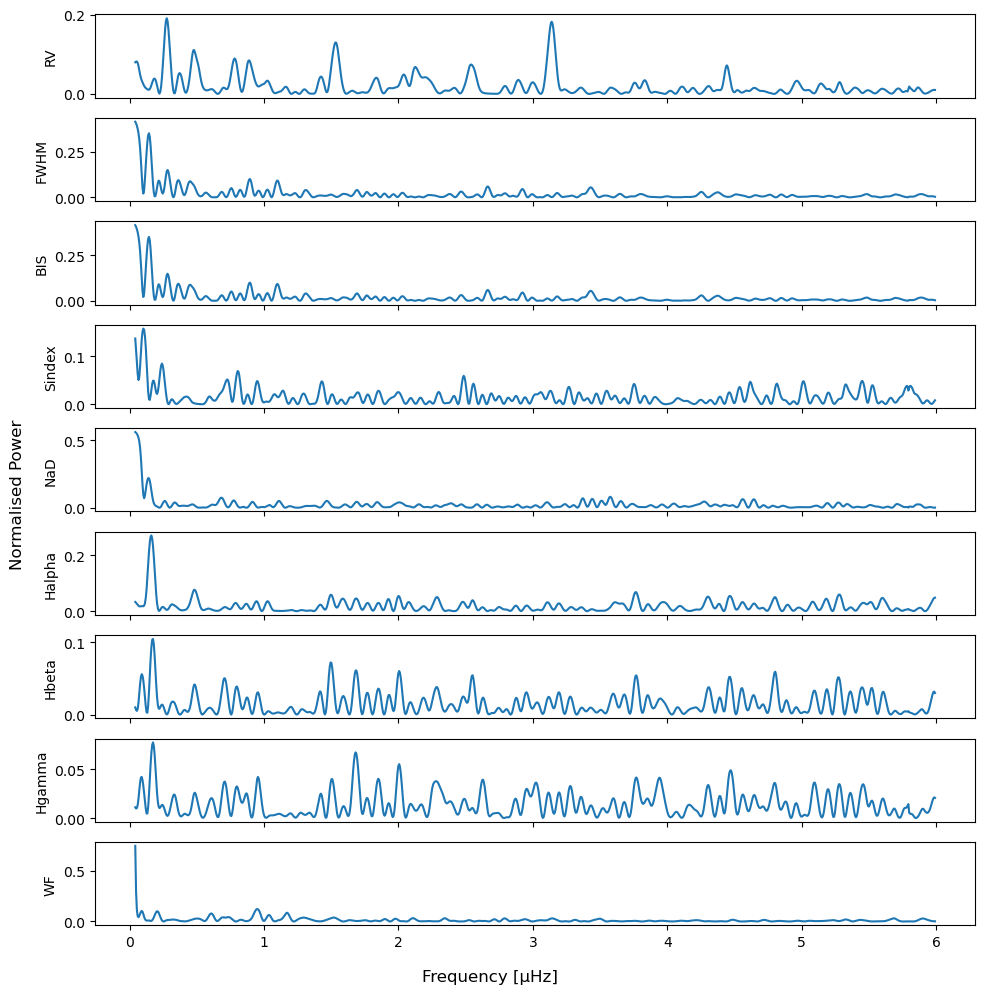

In [60]:
# Extract data
time = cleaned_df['Time']
activity_indices = ['RV', 'FWHM', 'BIS', 'Sindex', 'NaD', 'Halpha', 'Hbeta', 'Hgamma']

# Determine the frequency range
# min_frequency = 0.002025227467386652 # min frequency ESPRESSO
# (0.005187477566099779 + 0.002025227467386652) / 2 = 0.0036063525167432157
min_frequency = 0.0036063525167432157  # min frequency HARPS
max_frequency = 0.5177264355163222   # max frequency HARPS
samples_per_peak = 10
normalization = 'standard'

# convert frequency to microhertz
def convert_to_microhertz(frequency_in_days):
    return frequency_in_days * 1e6 / 86400

# Perform the Lomb-Scargle periodogram
def compute_periodogram(time, data, min_frequency=min_frequency, max_frequency=max_frequency, normalization=normalization, samples_per_peak=samples_per_peak):

    frequency, power = LombScargle(time, data).autopower(
        minimum_frequency=min_frequency,
        maximum_frequency=max_frequency,
        normalization=normalization,
        samples_per_peak=samples_per_peak
    )
    return frequency, power

# Compute periodograms
periodograms = {}
for index in activity_indices:
    frequency, power = compute_periodogram(time, cleaned_df[index], min_frequency, max_frequency)
    periodograms[index] = (frequency, power)

# Compute the window function
observation_indicator = np.ones_like(time)
window_power = LombScargle(time, observation_indicator).power(frequency)
periodograms['WF'] = (frequency, window_power)  # Add the window function to the periodograms

# Plotting
fig, axes = plt.subplots(len(periodograms), 1, figsize=(10, 10), sharex=True)

for ax, (key, (frequency, power)) in zip(axes, periodograms.items()):
    ax.plot(convert_to_microhertz(frequency), power)
    ax.set_ylabel(key)

# common axis labels
fig.supxlabel('Frequency [µHz]')
fig.supylabel('Normalised Power')

plt.tight_layout()
plt.show()

### Finiding Peaks

In [61]:
# True values (accoridng to paper (D. S. Demangeon et al. 2021))
true_periods = [2.2531136, 3.6906777,  7.4507245, 12.796]

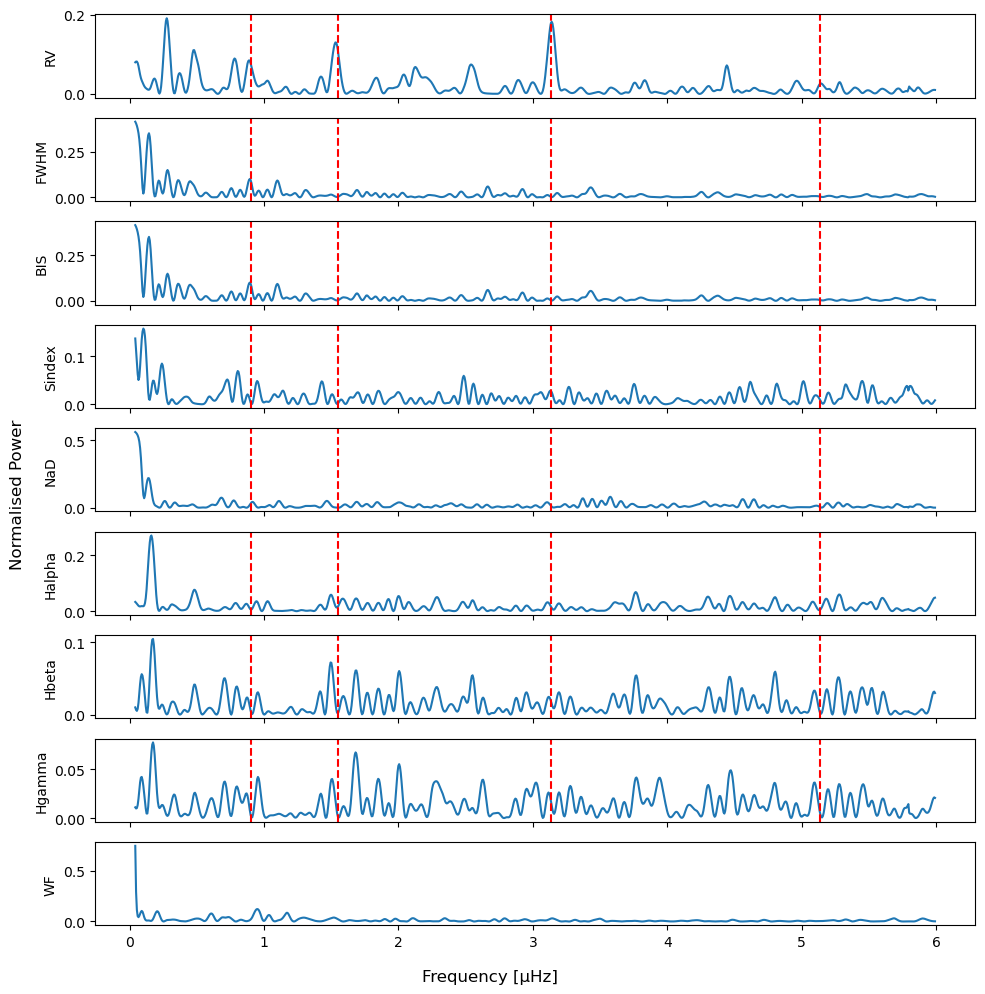

In [62]:
# Plotting
fig, axes = plt.subplots(len(periodograms), 1, figsize=(10, 10), sharex=True)

for i, (ax, (key, (frequency, power))) in enumerate(zip(axes, periodograms.items())):
    ax.plot(convert_to_microhertz(frequency), power)
    ax.set_ylabel(key)
    if i < len(axes) - 1:
        for peak in true_periods:
            ax.axvline(x=convert_to_microhertz(1 / peak), color='r', linestyle='--')


# common axis labels
fig.supxlabel('Frequency [µHz]')
fig.supylabel('Normalised Power')

plt.tight_layout()
plt.show()

### $log R^{'}_{\text{HK}} $ timeseries (S-index)

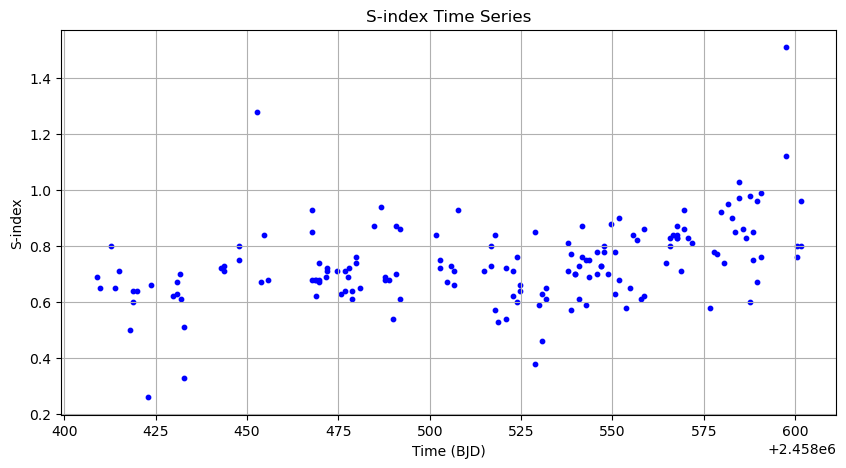

In [63]:
# Visualise s-index time series
plt.figure(figsize=(10, 5))
plt.scatter(cleaned_df['Time'], cleaned_df['Sindex'], s=10, c='blue')
plt.xlabel('Time (BJD)')
plt.ylabel('S-index')
plt.title('S-index Time Series')
plt.grid(True)
plt.show()

### Fit GP to S-index

In [136]:
# Data
time = cleaned_df['Time']
s_index_values = cleaned_df['Sindex']
s_index_error = cleaned_df['e_Sindex']


# Hyperparameters: amplitude, decay scale, periodicity scale, period
A = 0.2  # Amplitude
l = 30.0  # Decay timescale
Gamma = 2.0  # Periodic amplitude
P = 2.0  # Period

# Define the compostie kernel
kernel = A * kernels.ExpSquaredKernel(metric=l**2) * \
         kernels.ExpSine2Kernel(gamma=Gamma, log_period=np.log(P))

# Initialise the GP
gp = george.GP(kernel)

# Optimisation functions
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(s_index_values, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(s_index_values, quiet=True)

# Compute the initial guess
gp.compute(time, s_index_error)
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(s_index_values)))

# Optimisation routine
p0 = gp.get_parameter_vector()
result = minimize(nll, p0, jac=grad_nll, method='L-BFGS-B')
print(result)

# Update the GP with the optimised parameters
gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(s_index_values)))


Initial ln-likelihood: 59.86
      fun: -69.6410910691979
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.47551034e-02, -3.12482971e+00,  4.23772803e+00, -4.89733210e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([-1.66529924,  7.47898618,  1.46182035,  0.7063071 ])

Final ln-likelihood: 69.64


In [137]:
# After the optimization has completed
optimized_parameters = gp.get_parameter_vector()

# Print the optimized hyperparameters
print("Optimised Hyperparameters:")
print("Amplitude (A):", np.exp(optimized_parameters[0]))
print("Decay Timescale (l):", np.sqrt(np.exp(optimized_parameters[1])))
print("Periodic Amplitude (Gamma):", np.exp(optimized_parameters[2]))
print("Period (P):", np.exp(optimized_parameters[3]))

Optimised Hyperparameters:
Amplitude (A): 0.189134053567525
Decay Timescale (l): 42.07665567945323
Periodic Amplitude (Gamma): 4.313805008307217
Period (P): 2.02649377903959


### MCMC to tune the GP hyperparameters

In [138]:
# Define log likelihood
def lnprob_pre(p):
    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(s_index_values, quiet=True)
    # Simple flat prior: log(1) if in bounds, log(0) otherwise
    if np.any((-10 > p) | (p > 10)):
        return -np.inf  # log(0)
    return ll if np.isfinite(ll) else -1e25

# Set up the sampler.
nwalkers, ndim = 32, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_pre)

# Initialize the walkers.
p0 = [gp.get_parameter_vector() + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

# Run MCMC.
print("Running MCMC...")
sampler.run_mcmc(p0, 5000, progress=True)
print("Done.")

Running MCMC...


100%|██████████| 5000/5000 [02:50<00:00, 29.26it/s]

Done.


Too few points to create valid contours
Pre Mean Hyperparameters:
Amplitude (A): 0.25536670790732735
Decay Timescale (l): 85.83612664621262
Periodic Amplitude (Gamma): 2.053792463902972
Period (P): 2.036917411348757


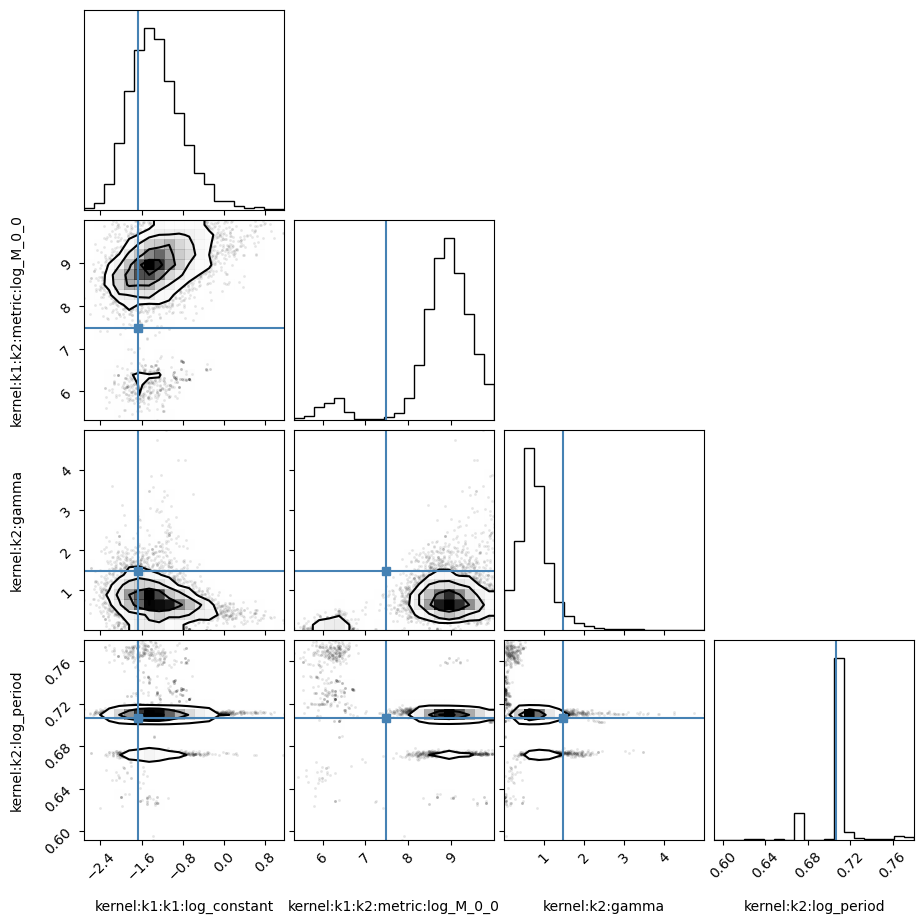

In [142]:
samples = sampler.get_chain(discard=2000, thin=15, flat=True)

figure = corner.corner(samples, labels=gp.get_parameter_names(), truths=optimized_parameters)

# Mean and covariance of the samples can be used to initialize the GP.
gp_mean = np.median(samples, axis=0)
gp.set_parameter_vector(gp_mean)

print("Pre Mean Hyperparameters:")
print("Amplitude (A):", np.exp(gp_mean[0]))
print("Decay Timescale (l):", np.sqrt(np.exp(gp_mean[1])))
print("Periodic Amplitude (Gamma):", np.exp(gp_mean[2]))
print("Period (P):", np.exp(gp_mean[3]))

### Visualise GP

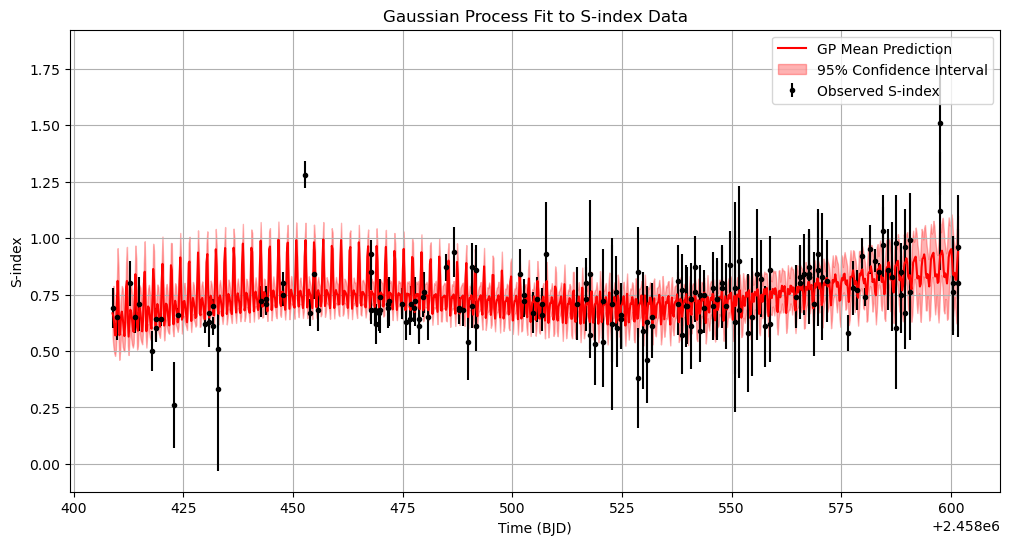

In [143]:
# Prediction points
t_pred = np.linspace(min(time), max(time), 1000)  # 1000 points for smoothness
mean, cov = gp.predict(s_index_values, t_pred, return_cov=True)  # Mean and covariance of the prediction
std = np.sqrt(np.diag(cov))  # Standard deviation at each predicted point

# Plot
plt.figure(figsize=(12, 6))
plt.errorbar(time, s_index_values, yerr=s_index_error, fmt=".k", capsize=0, label='Observed S-index')
plt.plot(t_pred, mean, 'r', lw=1.5, label='GP Mean Prediction')
plt.fill_between(t_pred, mean - 1.96 * std, mean + 1.96 * std, color='red', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Time (BJD)')
plt.ylabel('S-index')
plt.title('Gaussian Process Fit to S-index Data')
plt.legend()
plt.grid(True)
plt.show()